<a href="https://colab.research.google.com/github/elhamshaerirahbar-bot/my-colab-project/blob/main/Untitled17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas tensorflow

In [3]:
# Import necessary libraries for machine learning project

# Basic data handling
import numpy as np
import pandas as pd
import re                    # For text processing
import unicodedata          # For handling special characters

# Machine learning tools
from sklearn.model_selection import train_test_split    # Split data into train/test
from sklearn.preprocessing import StandardScaler, MinMaxScaler    # Scale data

# Deep learning with TensorFlow
import tensorflow as tf
from tensorflow.keras import layers, callbacks

# Model evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error


In [4]:
import pandas as pd

# Just read the file
df = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')
print(df.head())

   Run  Factor A  Factor B  Factor C  Factor D  Response 1 (Experimental)  \
0    1       110         7        50        10                    1127.19   
1    2        85        13        50        10                    1024.97   
2    3       101         1       500        60                    1950.00   
3    4       101         1       500        60                    2223.17   
4    5        50        10        50        10                    1845.60   

   Response 2 (Experimental)  
0                    1321.65  
1                    1339.35  
2                    2878.90  
3                    2989.00  
4                    2690.50  


In [5]:
#select columns by position
X = df.iloc[:, 1:5].astype(float).to_numpy()  # First 4 columns as features
y = df.iloc[:, 5:7].astype(float).to_numpy()  # Next 2 columns as targets

print("X:", X.shape, " y:", y.shape)

X: (25, 4)  y: (25, 2)


In [6]:
from scipy.stats import rankdata
from sklearn.preprocessing import KBinsDiscretizer

SEED = 5

def choose_bins(n_samples, min_per_bin=3, max_bins=5):
    # Pick a safe upper bound before knowing split sizes
    return max(2, min(max_bins, n_samples // min_per_bin))

# Build combined rank key from both targets
y_score = rankdata(y[:,0]) + rankdata(y[:,1])

# FIRST SPLIT: TrainVal / Test
test_frac = 0.10
n_test = int(np.ceil(len(y) * test_frac))
n_bins_1 = choose_bins(len(y))
n_bins_1 = max(2, min(n_bins_1, n_test))  # Hard cap by test samples

kbin1 = KBinsDiscretizer(n_bins=n_bins_1, encode='ordinal', strategy='quantile')
y_bins_1 = kbin1.fit_transform(y_score.reshape(-1,1)).ravel().astype(int)

X_trainval, X_test, y_trainval, y_test, bins_tv_init, bins_te = train_test_split(
    X, y, y_bins_1, test_size=test_frac, shuffle=True, random_state=SEED, stratify=y_bins_1
)

# SECOND SPLIT: Train / Val
val_frac_of_trainval = 0.1111
n_val = int(np.ceil(len(y_trainval) * val_frac_of_trainval))
y_score_tv = rankdata(y_trainval[:,0]) + rankdata(y_trainval[:,1])
n_bins_2 = choose_bins(len(y_trainval))
n_bins_2 = max(2, min(n_bins_2, n_val))

kbin2 = KBinsDiscretizer(n_bins=n_bins_2, encode='ordinal', strategy='quantile')
y_bins_2 = kbin2.fit_transform(y_score_tv.reshape(-1,1)).ravel().astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_frac_of_trainval,
    shuffle=True, random_state=SEED, stratify=y_bins_2
)

print("Shapes:")
print("  X:", X_train.shape, X_val.shape, X_test.shape)
print("  y:", y_train.shape, y_val.shape, y_test.shape)

Shapes:
  X: (19, 4) (3, 4) (3, 4)
  y: (19, 2) (3, 2) (3, 2)


C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [7]:
# Scale input features (X) using StandardScaler
x_scaler = StandardScaler().fit(X_train)
X_train_z = x_scaler.transform(X_train)
X_val_z   = x_scaler.transform(X_val)
X_test_z  = x_scaler.transform(X_test)

# Scale target values (y) using MinMaxScaler to range [-1,1]
y_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(y_train)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

# Functions to convert predictions back to original scale
def inv_y(y_scaled):
    return y_scaler.inverse_transform(y_scaled)

def inv_y_cols(y_scaled):
    mn = y_scaler.inverse_transform(y_scaled)[:,0]
    mw = y_scaler.inverse_transform(y_scaled)[:,1]
    return mn, mw

print("y_train_s range per column (should be within [-1,1]):")
print(y_train_s.min(axis=0), y_train_s.max(axis=0))

y_train_s range per column (should be within [-1,1]):
[-1. -1.] [1. 1.]


In [8]:
ann = tf.keras.models.Sequential()

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, Callback
from tensorflow.keras import layers, regularizers, callbacks

SEED = 55
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Custom callback to stop training when MSE goal is reached
class StopOnMSEGoal(Callback):
    def __init__(self, goal=1e-5):
        super().__init__()
        self.goal = goal
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and logs.get('loss', 1.0) <= self.goal:
            self.model.stop_training = True

# Build neural network model
# Single hidden layer with 13 neurons, tanh activation
model = Sequential([
    Dense(13, activation='tanh', input_shape=(4,)),  # Hidden layer: 13 neurons
    Dense(2, activation='tanh')                      # Output: 2 neurons (Mn, Mw)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])

C:\Users\brian\PycharmProjects\PythonProject1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Compile model
model.compile(optimizer='adam', loss='mse')

# Setup callbacks
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
goal_cb = StopOnMSEGoal(goal=1e-5)

# Train the model
history = model.fit(
    X_train_z, y_train_s,
    validation_data=(X_val_z, y_val_s),
    epochs=100, batch_size=4, verbose=1,
    callbacks=[es, goal_cb]
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5738 - mae: 0.6180 - mape: 168.2290 - val_loss: 0.1354 - val_mae: 0.3267 - val_mape: 249.2565
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5444 - mae: 0.6022 - mape: 163.0690 - val_loss: 0.1335 - val_mae: 0.3277 - val_mape: 248.8945
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5164 - mae: 0.5874 - mape: 158.9162 - val_loss: 0.1314 - val_mae: 0.3280 - val_mape: 247.7719
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4889 - mae: 0.5723 - mape: 154.7919 - val_loss: 0.1292 - val_mae: 0.3276 - val_mape: 245.8473
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4621 - mae: 0.5568 - mape: 150.6182 - val_loss: 0.1268 - val_mae: 0.3265 - val_mape: 243.0849
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4361 - mae: 0.5411 - mape: 146.3854 - val_loss: 0.1243 - val_mae: 0.3247 - val_mape: 239.4736
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4111 - mae: 0.52

In [11]:
# Function to convert scaled predictions back to original values
def inv_y(y_s):
    return y_scaler.inverse_transform(y_s)

# Make predictions on test set
y_pred_test_s = model.predict(X_test_z)  # Scaled predictions
y_pred_test   = inv_y(y_pred_test_s)     # Convert back to original scale

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [12]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for each output separately
mse_Mn = mean_squared_error(y_test[:,0], y_pred_test[:,0])
mse_Mw = mean_squared_error(y_test[:,1], y_pred_test[:,1])

print(f"MSE(Mn) real = {mse_Mn:.4f} | MSE(Mw) real = {mse_Mw:.4f}")

# Show model architecture
model.summary()

MSE(Mn) real = 3848.7276 | MSE(Mw) real = 464755.7013


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 13)                  │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              28 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281 (1.10 KB)

 Trainable params: 93 (372.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 188 (756.00 B)

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred_test_s = model.predict(X_test_z)
y_pred_test   = y_scaler.inverse_transform(y_pred_test_s)

# Calculate metrics for each output
mse_Mn = mean_squared_error(y_test[:,0], y_pred_test[:,0])
mse_Mw = mean_squared_error(y_test[:,1], y_pred_test[:,1])
r2_Mn  = r2_score(y_test[:,0], y_pred_test[:,0])
r2_Mw  = r2_score(y_test[:,1], y_pred_test[:,1])
r2_avg = r2_score(y_test, y_pred_test, multioutput='uniform_average')

print(f"MSE(Mn) real = {mse_Mn:.6f} | MSE(Mw) real = {mse_Mw:.6f}")
print(f"R² (Mn)      = {r2_Mn:.4f}  | R² (Mw)      = {r2_Mw:.4f}  | R²_avg = {r2_avg:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MSE(Mn) real = 3848.727613 | MSE(Mw) real = 464755.701260
R² (Mn)      = 0.9835  | R² (Mw)      = -13.1481  | R²_avg = -6.0823


In [14]:
# Define additional evaluation metrics
def rmse(a, b): 
    return np.sqrt(mean_squared_error(a, b))

def sep(a, b):
    n = len(a)
    return np.sqrt(np.sum((a-b)**2)/(n-1)) #root function

# Evaluate each output with multiple metrics
for j, name in enumerate(['Mn', 'Mw']):
    print(f'{name}: RMSE={rmse(y_test[:,j], y_pred_test[:,j]):.3f} | '
          f'R²={r2_score(y_test[:,j], y_pred_test[:,j]):.4f} | '
          f'SEP={sep(y_test[:,j], y_pred_test[:,j]):.3f}')

Mn: RMSE=62.038 | R²=0.9835 | SEP=75.981
Mw: RMSE=681.730 | R²=-13.1481 | SEP=834.945


In [15]:
# Make predictions on all datasets (scaled space first, then convert to real units)
y_hat_train_s = model.predict(X_train_z, verbose=1)  # Train predictions (scaled)
y_hat_val_s   = model.predict(X_val_z,   verbose=1)  # Validation predictions (scaled)
y_hat_test_s  = model.predict(X_test_z,  verbose=1)  # Test predictions (scaled)

# Convert predictions back to original scale
y_hat_train = inv_y(y_hat_train_s)  # Train predictions (real units)
y_hat_val   = inv_y(y_hat_val_s)    # Validation predictions (real units)
y_hat_test  = inv_y(y_hat_test_s)   # Test predictions (real units)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def report_2out(name, yt, yp, labels=("Mn", "Mw")):
    # yt and yp should be (n,2) arrays
    for i, label in enumerate(labels):
        y_true = yt[:, i].reshape(-1)
        y_pred = yp[:, i].reshape(-1)
        
        mae  = mean_absolute_error(y_true, y_pred)
        mse  = mean_squared_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        
        print(f"[{name}] {label}: MAE={mae:.6f}  MSE={mse:.6f}  R²={r2:.4f}  MAPE={mape:.6f}")

In [18]:
report_2out("Train", y_train, y_hat_train)
report_2out("Val  ", y_val,   y_hat_val)
report_2out("Test ", y_test,  y_hat_test)

[Train] Mn: MAE=476.610387  MSE=388125.670932  R²=0.6494  MAPE=0.215762
[Train] Mw: MAE=791.616960  MSE=869600.668607  R²=0.6025  MAPE=0.274821
[Val  ] Mn: MAE=289.001493  MSE=107050.073151  R²=-1.4086  MAPE=0.119096
[Val  ] Mw: MAE=455.264733  MSE=217647.265093  R²=-2.3712  MAPE=0.146577
[Test ] Mn: MAE=54.671335  MSE=3848.727613  R²=0.9835  MAPE=0.024822
[Test ] Mw: MAE=483.710072  MSE=464755.701260  R²=-13.1481  MAPE=0.163630


In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1) Make predictions in scaled space
y_pred_train_s = model.predict(X_train_z)
y_pred_val_s   = model.predict(X_val_z)
y_pred_test_s  = model.predict(X_test_z)

# 2) Convert predictions back to real units (IMPORTANT)
y_pred_train = y_scaler.inverse_transform(y_pred_train_s)
y_pred_val   = y_scaler.inverse_transform(y_pred_val_s)
y_pred_test  = y_scaler.inverse_transform(y_pred_test_s)

# Check that y_true is in real units
print('y_train real min/max per col:', y_train.min(axis=0), y_train.max(axis=0))

# 3) R² scores for Mn and Mw separately
print("Train R2:", r2_score(y_train, y_pred_train, multioutput='raw_values'))
print("Val   R2:", r2_score(y_val,   y_pred_val,   multioutput='raw_values'))
print("Test  R2:", r2_score(y_test,  y_pred_test,  multioutput='raw_values'))

# 4) Other metrics in real units
def eval_block(name, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmse = (mse**0.5)
    mae  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    
    # Manual MAPE calculation (avoid division by zero)
    eps = 1e-12
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)), axis=0) * 100
    
    print(f"{name} -> MSE={mse}, RMSE={rmse}, MAE={mae}, MAPE%={mape}")

# Evaluate all datasets
for split, y_true, y_pred in [
    ("Train", y_train, y_pred_train),
    ("Val",   y_val,   y_pred_val),
    ("Test",  y_test,  y_pred_test)
]:
    eval_block(split, y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
y_train real min/max per col: [1024.97 1321.65] [4663.77 5921.61]
Train R2: [0.64938358 0.60247255]
Val   R2: [-1.40863543 -2.37124696]
Test  R2: [  0.98348107 -13.14813839]
Train -> MSE=[388125.67093235 869600.66860713], RMSE=[622.99732819 932.52381664], MAE=[476.61038728 791.61695955], MAPE%=[21.57622813 27.48212798]
Val -> MSE=[107050.07315054 217647.26509333], RMSE=[327.18507477 466.52681069], MAE=[289.00149349 455.26473307], MAPE%=[11.90964369 14.65769136]
Test -> MSE=[  3848.72761283 464755.70126038], RMSE=[ 62.03811419 681.72993279], MAE=[ 54.67133464 483.71007161], MAPE%=[ 2.48218451 16.36296434]


In [20]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def summarize_split(name, y_true, y_pred):
    var = np.var(y_true, axis=0, ddof=1)
    mse = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    r2  = r2_score(y_true, y_pred, multioutput='raw_values')
    
    # Baseline = predicting mean of y_true
    y_mean = np.tile(np.mean(y_true, axis=0, keepdims=True), (y_true.shape[0],1))
    mse_base = mean_squared_error(y_true, y_mean, multioutput='raw_values')
    r2_base  = r2_score(y_true, y_mean, multioutput='raw_values')
    
    print(f"{name}: Var={var} | R2={r2} | RMSE={rmse} | MAE={mae}")
    print(f"       (Baseline R2={r2_base}, Baseline RMSE={np.sqrt(mse_base)})")

# Evaluate all splits with baseline comparison
summarize_split("Train", y_train, y_pred_train)
summarize_split("Val",   y_val,   y_pred_val)
summarize_split("Test",  y_test,  y_pred_test)

Train: Var=[1168479.8233924  2309052.66440058] | R2=[0.64938358 0.60247255] | RMSE=[622.99732819 932.52381664] | MAE=[476.61038728 791.61695955]
       (Baseline R2=[0. 0.], Baseline RMSE=[1052.13159126 1479.02791617])
Val: Var=[66666.423513   96839.80493333] | R2=[-1.40863543 -2.37124696] | RMSE=[327.18507477 466.52681069] | MAE=[289.00149349 455.26473307]
       (Baseline R2=[0. 0.], Baseline RMSE=[210.81812622 254.0863435 ])
Test: Var=[349483.3351      49273.87143333] | R2=[  0.98348107 -13.14813839] | RMSE=[ 62.03811419 681.72993279] | MAE=[ 54.67133464 483.71007161]
       (Baseline R2=[0. 0.], Baseline RMSE=[482.68922721 181.24361402])


In [21]:
!pip install matplotlib

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import numpy as np, pandas as pd

def make_table_multi(split, y_true, y_pred, target_names=("Mn","Mw"), n=None):
    """
    Build table for 2 (or more) outputs.
    y_true, y_pred: shape (n, k) -> k = number of outputs (here 2: Mn, Mw)
    pct_error in percent (0–100).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    assert y_true.shape == y_pred.shape and y_true.ndim == 2, "y must be (n,k)"
    k = y_true.shape[1]
    assert k == len(target_names), "target_names length doesn't match y.shape[1]"
    
    parts = []
    for j, name in enumerate(target_names):
        df = pd.DataFrame({
            "split":     split,
            "target":    name,
            "actual":    y_true[:, j],
            "predicted": y_pred[:, j],
        })
        df["residual"]  = df["actual"] - df["predicted"]
        df["abs_error"] = df["residual"].abs()
        # Percent error (×100)
        df["pct_error"] = 100 * df["abs_error"] / df["actual"].abs().clip(lower=1e-8)
        
        parts.append(df if n is None else df.head(n))
    
    return pd.concat(parts, ignore_index=True)

# Create tables for all datasets
tbl_train = make_table_multi("Train", y_train, y_hat_train, target_names=("Mn","Mw"))
tbl_val   = make_table_multi("Val",   y_val,   y_hat_val,   target_names=("Mn","Mw"))
tbl_test  = make_table_multi("Test",  y_test,  y_hat_test,  target_names=("Mn","Mw"))

# Combine all tables
tbl_all = pd.concat([tbl_train, tbl_val, tbl_test], ignore_index=True)
print(tbl_all.to_string(index=False))

split target   actual   predicted     residual   abs_error  pct_error
Train     Mn 2322.830 2005.047607   317.782393  317.782393  13.680829
Train     Mn 3764.530 3525.262695   239.267305  239.267305   6.355835
Train     Mn 1264.440 1653.019775  -388.579775  388.579775  30.731373
Train     Mn 3762.880 3525.262695   237.617305  237.617305   6.314772
Train     Mn 2951.900 3009.844482   -57.944482   57.944482   1.962955
Train     Mn 1846.180 1936.507080   -90.327080   90.327080   4.892648
Train     Mn 1950.000 2257.272949  -307.272949  307.272949  15.757587
Train     Mn 4663.770 3488.834229  1174.935771 1174.935771  25.192833
Train     Mn 2525.910 1940.624268   585.285732  585.285732  23.171282
Train     Mn 2073.900 1986.119141    87.780859   87.780859   4.232647
Train     Mn 2525.270 1940.624268   584.645732  584.645732  23.151811
Train     Mn 2298.650 3480.682617 -1182.032617 1182.032617  51.422905
Train     Mn 1265.880 1653.019775  -387.139775  387.139775  30.582660
Train     Mn 2298.62

In [24]:
#reproducibility
SEED = 5
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [25]:
# Activation (Transfer Function) sweep on hidden layers
import random, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, optimizers

activations = ['relu', 'tanh', 'sigmoid', 'softplus']
labels      = ['ReLU', 'Tanh', 'Sigmoid', 'Softplus']
val_mse_real  = []
test_mse_real = []

In [26]:
for act in activations:

    tf.keras.backend.clear_session()
    np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)

    model = tf.keras.Sequential([
        layers.Input(shape=(X_train_z.shape[1],)),
        layers.Dense(16, activation=act),
        layers.Dense(2,  activation='tanh')     # zwei Ausgänge: [Mn, Mw]
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='mse', metrics=['mae'])

    history = model.fit(
        X_train_z, y_train_s,                    # y_train_s: (n,2)
        validation_data=(X_val_z, y_val_s),
        epochs=200, batch_size=16, shuffle=True, verbose=1,
        callbacks=[]
    )


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.9669 - mae: 0.8478 - val_loss: 0.5025 - val_mae: 0.6332
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9502 - mae: 0.8392 - val_loss: 0.4945 - val_mae: 0.6264
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.9349 - mae: 0.8313 - val_loss: 0.4865 - val_mae: 0.6197
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9198 - mae: 0.8233 - val_loss: 0.4784 - val_mae: 0.6128
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.9049 - mae: 0.8154 - val_loss: 0.4704 - val_mae: 0.6061
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8902 - mae: 0.8075 - val_loss: 0.4624 - val_mae: 0.6020
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.8757 - mae: 0.7995 - val_loss: 0.4544 - val_mae: 0.5979
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.8614 - mae: 0.7915 - val_loss: 0.4464 - val_mae: 0.5937
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.8473 - mae

In [27]:
    # Vorhersage (skaliert) -> zurückskalieren
    y_hat_train_s = model.predict(X_train_z, verbose=0)
    y_hat_val_s   = model.predict(X_val_z,   verbose=0)
    y_hat_test_s  = model.predict(X_test_z,  verbose=0)

    y_hat_train = inv_y(y_hat_train_s)          # (n,2) in realen Einheiten
    y_hat_val   = inv_y(y_hat_val_s)
    y_hat_test  = inv_y(y_hat_test_s)

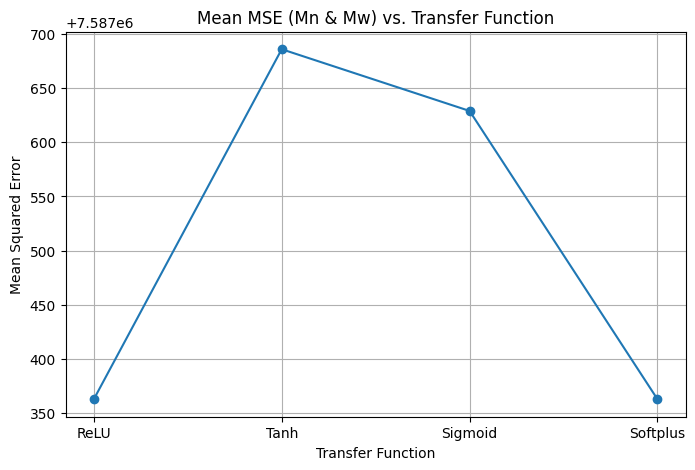

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

transfer_functions = {
    'relu': 'ReLU',
    'tanh': 'Tanh',
    'sigmoid': 'Sigmoid',
    'softplus': 'Softplus'
}

mse_results = []

for activation, name in transfer_functions.items():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(16, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='tanh'))   #  zwei Outputs: [Mn, Mw]
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, batch_size=4, epochs=50, verbose=0)
    y_pred = model.predict(X_test, verbose=0)  # Form (n,2)
    # Durchschnitts-MSE über beide Outputs (Mn & Mw)
    mse = mean_squared_error(y_test, y_pred)   # = uniform_average
    mse_results.append(mse)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(list(transfer_functions.values()), mse_results, marker='o', linestyle='-')
plt.title('Mean MSE (Mn & Mw) vs. Transfer Function')
plt.xlabel('Transfer Function')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

In [29]:
# Reshape y to match X dimensions
y = y.reshape(X.shape[0], 2)   # Now y.shape == (25, 2)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict

# Create pipeline with scaling and linear regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred = cross_val_predict(pipe, X, y, cv=cv)

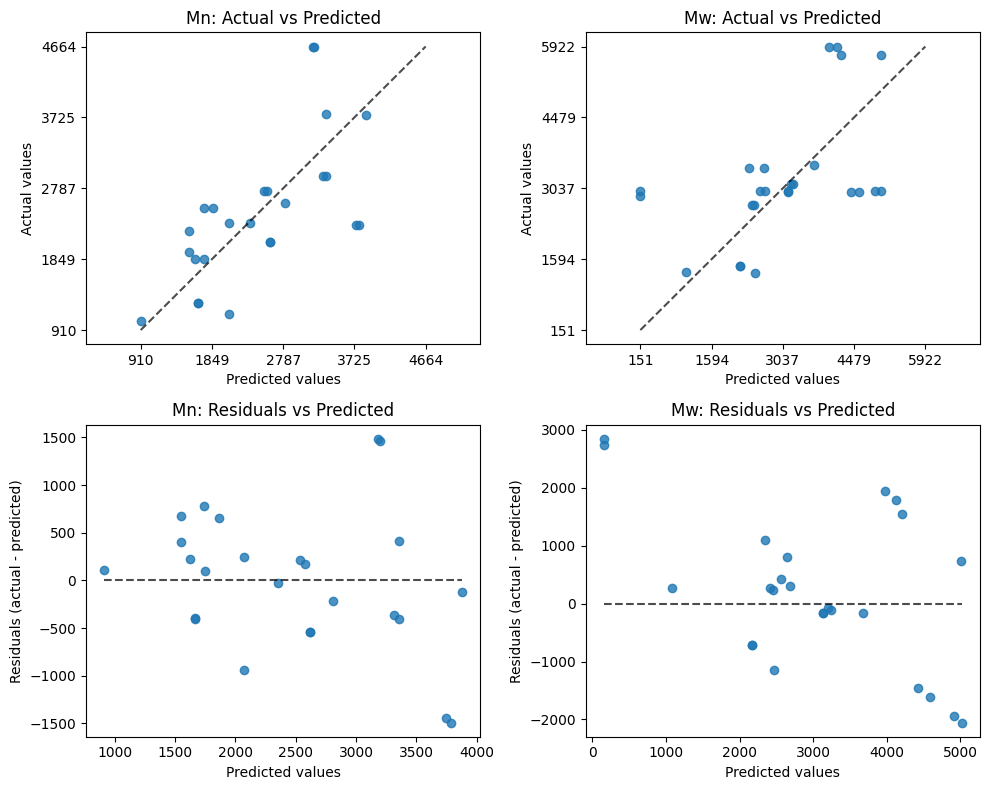

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
names = ["Mn", "Mw"]

for j in range(2):
    PredictionErrorDisplay.from_predictions(
        y_true=y[:, j], y_pred=y_pred[:, j],
        kind="actual_vs_predicted", subsample=None, ax=axs[0, j], random_state=42
    )
    axs[0, j].set_title(f"{names[j]}: Actual vs Predicted")

    PredictionErrorDisplay.from_predictions(
        y_true=y[:, j], y_pred=y_pred[:, j],
        kind="residual_vs_predicted", subsample=None, ax=axs[1, j], random_state=42
    )
    axs[1, j].set_title(f"{names[j]}: Residuals vs Predicted")

plt.tight_layout(); plt.show()

In [211]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_percentage_error, mean_squared_error,
    mean_squared_log_error, explained_variance_score, max_error,
    median_absolute_error
)

In [32]:
import pandas as pd

# Just read the file
df = pd.read_csv('Exp_Mn_Mw_Value.txt', sep='\t')
print(df.head())
#select columns by position
X = df.iloc[:, 1:5].astype(float).to_numpy()  # First 4 columns as features
y = df.iloc[:, 5:7].astype(float).to_numpy()  # Next 2 columns as targets

print("X:", X.shape, " y:", y.shape)

   Run  Factor A  Factor B  Factor C  Factor D  Response 1 (Experimental)  \
0    1       110         7        50        10                    1127.19   
1    2        85        13        50        10                    1024.97   
2    3       101         1       500        60                    1950.00   
3    4       101         1       500        60                    2223.17   
4    5        50        10        50        10                    1845.60   

   Response 2 (Experimental)  
0                    1321.65  
1                    1339.35  
2                    2878.90  
3                    2989.00  
4                    2690.50  
X: (25, 4)  y: (25, 2)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_trval, X_test, y_trval, y_test = train_test_split(
    X, y, test_size=5, random_state=42, shuffle=True
)

n_samples = X.shape[0]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_trval.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Total: {n_samples} samples\n")

Training set: 20 samples
Validation set: 20 samples
Test set: 5 samples
Total: 25 samples



In [37]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

# Create SVR pipeline with scaling
base_svr = make_pipeline(
    StandardScaler(),
    SVR(kernel='poly', C=1, epsilon=0.1, gamma='scale')
)

# Wrap for multi-output regression (Mn and Mw)
model = MultiOutputRegressor(base_svr)

# Train the model
model.fit(X_train, y_train)

,estimator,Pipeline(step...nel='poly'))])
,n_jobs,None
,copy,True
,with_mean,True
,with_std,True
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1


In [41]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    explained_variance_score,
    mean_absolute_percentage_error,
    mean_squared_log_error,
    median_absolute_error
)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Print the shape of the predicted output
print("Test predictions shape:", y_pred.shape)


# Define a function to calculate multiple evaluation metrics
def overall_metrics(y_true, y_pred):
    # R² score: how well predictions approximate real data
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')
    
    # Explained variance score: proportion of variance explained by the model
    evs = explained_variance_score(y_true, y_pred, multioutput='uniform_average')
    
    # Mean Absolute Percentage Error (MAPE): average percentage error
    mape = mean_absolute_percentage_error(y_true, y_pred, multioutput='uniform_average')
    
    # Mean Squared Error (MSE): average of squared errors
    mse = mean_squared_error(y_true, y_pred, multioutput='uniform_average')
    
    # Mean Squared Logarithmic Error (MSLE): penalizes underestimation (may fail if y < 0)
    try:
        msle = mean_squared_log_error(y_true, y_pred, multioutput='uniform_average')
    except ValueError:
        msle = np.nan  # If negative values exist, MSLE is not valid
    
    # Median Absolute Error (Median AE): median of absolute errors, averaged across outputs
    mae_med = np.mean([median_absolute_error(y_true[:, i], y_pred[:, i]) 
                       for i in range(y_true.shape[1])])
    
    # Max Error: largest absolute error among all predictions
    maxerr = np.max(np.abs(y_true - y_pred))
    
    return evs, maxerr, mape, mse, msle, mae_med, r2


# Calculate metrics on the test set
evs, maxerr, mape, mse, msle, mae_med, r2 = overall_metrics(y_test, y_pred)

# Print results
print("SVM Results:")
print(f"Explained Variance: {evs:.6f}")
print(f"Max Error: {maxerr:.6f}")
print(f"MAPE: {mape:.6f}")
print(f"MSE: {mse:.6f}")
print(f"MSLE: {msle:.6f}")
print(f"Median AE: {mae_med:.6f}")
print(f"R²: {r2:.6f}\n")


Test predictions shape: (5, 2)
SVM Results:
Explained Variance: 0.002493
Max Error: 2775.172025
MAPE: 0.340183
MSE: 1434268.194172
MSLE: 0.190013
Median AE: 327.910881
R²: -0.032165



In [42]:
import pandas as pd

# Create a DataFrame to compare actual vs predicted values for Mn and Mw
test_df = pd.DataFrame({
    "Actual_Mn":    y_test[:, 0],   # True values for Mn
    "Actual_Mw":    y_test[:, 1],   # True values for Mw
    "Predicted_Mn": y_pred[:, 0],   # Predicted values for Mn
    "Predicted_Mw": y_pred[:, 1],   # Predicted values for Mw
})

# Print comparison table without row indices
print("Actual vs Predicted Comparison (Test):")
print(test_df.to_string(index=False))
print()


Actual vs Predicted Comparison (Test):
 Actual_Mn  Actual_Mw  Predicted_Mn  Predicted_Mw
   2298.62    2972.98   2311.262111   2977.820177
   3762.88    5752.81   2311.230178   2977.637975
   1127.19    1321.65   2307.094083   2972.456813
   2955.83    2966.91   2310.916810   2977.137801
   2322.83    2987.31   2310.247889   2976.401428



In [43]:
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Initialize KFold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
r2_list, mse_list, mape_list = [], [], []

# Perform cross-validation
for tr_idx, va_idx in kf.split(X):
    # Split data into training and validation sets
    X_tr, X_va = X[tr_idx], X[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]
    
    # Define model: Multi-output regression with pipeline (scaler + polynomial SVR)
    m = MultiOutputRegressor(
        make_pipeline(
            StandardScaler(),
            SVR(kernel='poly', C=1, epsilon=0.1, gamma='scale')
        )
    )
    
    # Train the model on training fold
    m.fit(X_tr, y_tr)
    
    # Predict on validation fold
    y_va_pred = m.predict(X_va)
    
    # Append evaluation metrics
    r2_list.append(r2_score(y_va, y_va_pred, multioutput='uniform_average'))
    mse_list.append(mean_squared_error(y_va, y_va_pred, multioutput='uniform_average'))
    mape_list.append(mean_absolute_percentage_error(y_va, y_va_pred, multioutput='uniform_average'))

# Convert lists to numpy arrays for easier aggregation
r2_arr   = np.array(r2_list)
mse_arr  = np.array(mse_list)
mape_arr = np.array(mape_list)

# Print summary of cross-validation results
print("\n5-FOLD CROSS VALIDATION RESULTS")

print(f"R² Mean:   {r2_arr.mean():.4f} (±{r2_arr.std():.4f})")
print(f"MSE Mean:  {mse_arr.mean():.4f} (±{mse_arr.std():.4f})")
print(f"MAPE Mean: {mape_arr.mean():.4f} (±{mape_arr.std():.4f})\n")

# Print individual fold scores
print("Individual R² scores:", np.array2string(r2_arr, precision=4))
print("Individual MSE scores:", np.array2string(mse_arr, precision=4))
print("Individual MAPE scores:", np.array2string(mape_arr, precision=4))



5-FOLD CROSS VALIDATION RESULTS
R² Mean:   -0.1353 (±0.0820)
MSE Mean:  1328342.8102 (±1036830.9413)
MAPE Mean: 0.3033 (±0.1688)

Individual R² scores: [-0.0322 -0.1757 -0.1002 -0.0965 -0.2717]
Individual MSE scores: [1434268.1942  529840.2238   99664.4658 3116920.9216 1461020.2455]
Individual MAPE scores: [0.3402 0.3302 0.1134 0.5858 0.1467]


In [44]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Train final model on all available data (using RBF kernel SVR)
model_all = MultiOutputRegressor(
    make_pipeline(
        StandardScaler(),
        SVR(kernel='rbf', C=10.0, epsilon=0.01, gamma='scale')
    )
)
model_all.fit(X, y)

# Predict on the full dataset
y_all_pred = model_all.predict(X)

# Build a DataFrame to compare actual vs predicted values
all_df = pd.DataFrame({
    "Sample": np.arange(1, X.shape[0] + 1),  # Sample numbering
    "Actual_Mn":    y[:, 0],
    "Actual_Mw":    y[:, 1],
    "Predicted_Mn": y_all_pred[:, 0],
    "Predicted_Mw": y_all_pred[:, 1],
})

# Compute absolute errors for each sample
all_df["Error_Mn"] = (all_df["Actual_Mn"] - all_df["Predicted_Mn"]).abs()
all_df["Error_Mw"] = (all_df["Actual_Mw"] - all_df["Predicted_Mw"]).abs()

# Print sample-by-sample comparison
print("\nActual vs Predicted Comparison (All samples):")
for i, row in all_df.iterrows():
    a_mn, a_mw = row["Actual_Mn"], row["Actual_Mw"]
    p_mn, p_mw = row["Predicted_Mn"], row["Predicted_Mw"]
    print(f"Sample {int(row['Sample']):2d}: Actual=[ {a_mn:7.2f}, {a_mw:7.2f} ] | "
          f"Predicted=[ {p_mn:7.2f}, {p_mw:7.2f} ]")

# Print full comparison table
print("\nDetailed Comparison Table:")
print(all_df.to_string(index=False))



Actual vs Predicted Comparison (All samples):
Sample  1: Actual=[ 1127.19, 1321.65 ] | Predicted=[ 2278.61, 2939.98 ]
Sample  2: Actual=[ 1024.97, 1339.35 ] | Predicted=[ 2280.49, 2944.25 ]
Sample  3: Actual=[ 1950.00, 2878.90 ] | Predicted=[ 2295.80, 2971.61 ]
Sample  4: Actual=[ 2223.17, 2989.00 ] | Predicted=[ 2295.80, 2971.61 ]
Sample  5: Actual=[ 1845.60, 2690.50 ] | Predicted=[ 2292.39, 2955.20 ]
Sample  6: Actual=[ 1846.18, 2689.91 ] | Predicted=[ 2292.39, 2955.20 ]
Sample  7: Actual=[ 2073.90, 2974.51 ] | Predicted=[ 2307.34, 2972.61 ]
Sample  8: Actual=[ 2074.52, 2970.82 ] | Predicted=[ 2307.34, 2972.61 ]
Sample  9: Actual=[ 2298.62, 2972.98 ] | Predicted=[ 2343.73, 2981.66 ]
Sample 10: Actual=[ 2298.65, 2972.94 ] | Predicted=[ 2343.73, 2981.66 ]
Sample 11: Actual=[ 2322.86, 2987.28 ] | Predicted=[ 2322.83, 2987.28 ]
Sample 12: Actual=[ 2322.83, 2987.31 ] | Predicted=[ 2322.83, 2987.28 ]
Sample 13: Actual=[ 2752.80, 3129.61 ] | Predicted=[ 2334.40, 2993.36 ]
Sample 14: Actual